# Prereading data analysis

## Loading data and survey data

In [59]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import getpass
import math

In [60]:
# from scipy import stats 
dfraw = pd.read_csv('C:\Users\\'+getpass.getuser()+'\Desktop\Clean-data_160217_JBS_removed_empty_columns.csv')
dfsurvey = pd.read_csv('C:\Users\\'+getpass.getuser()+'\Desktop\Clean-data_addSurvey_160309_JBS_removed_empty_columns.csv')
#please read this about unicode strings eventually: http://www.joelonsoftware.com/articles/Unicode.html


# Klugetastic: make a list, convert to an array and then a df
datalist = []
#header = df.keys()
topics = ['Blackbody','Masses','Resonance']
treatments = ['TextThenPhet','TextOnly','PhetThenText']


#merge with main dataframe
dfmerged = pd.merge(left=dfraw,right=dfsurvey, left_on='anon-id', right_on='anon-id')

phetquestion = {'Blackbody':'q01 - Approximately how long did you spend with the PhET simulation? (in minutes)',
                'Masses':'q5 - Approximately how long did you spend with the PhET simulation? (in minutes)',
                'Resonance':'q6 - Approximately how long did you spend with the PhET simulation? (in minutes)'}
textquestion = {'Blackbody':'q02 - Approximately how long did you spend reading the textbook sections? (in minutes)',
                'Masses':'q6 - Approximately how long did you spend reading the textbook sections? (in minutes)',
                'Resonance':'q7 - Approximately how long did you spend reading the textbook sections? (in minutes)'}

#now we iterate through the dataframe and creat a row per student x topic
for index, row in dfmerged.iterrows():
    for topic in topics:
        datalist.append([str(row['anon-id']),
                        str(row["Reading group_x"]),
                        float(str(row['PreScore.'+topic]).replace('%',''))/100.0,
                        topic,
                        row['Treatment.'+topic+'_x'],
                        float(str(row['PostScore.'+topic]).replace('%',''))/100.0,
                        row[textquestion[topic]],
                        row[phetquestion[topic]]
                        ])

# convert list2 to an array then a dataframe
array2 = np.array(datalist)
colnames = ['student id',"Reading group",'Prescore for topic','Topic','Treatment for topic',
            'Postscore for topic','Time on text for topic','Time on PhET for topic']
df = pd.DataFrame(array2,columns=colnames)

## Organizing the dataframe

Now that we have our data frame we can see what it looks like:

In [61]:
df.head()

,student id,Reading group,Prescore for topic,Topic,Treatment for topic,Postscore for topic,Time on text for topic,Time on PhET for topic
0,5963,3,nan,Blackbody,TextOnly,1.0,nan,nan
1,5963,3,nan,Masses,TextThenPhet,1.0,25.0,7.0
2,5963,3,nan,Resonance,PhetThenText,0.67,20.0,6.0
3,25630,1,0.33,Blackbody,PhetThenText,0.67,nan,nan
4,25630,1,0.0,Masses,TextOnly,0.0,20.0,0.0


First we want to make sure that the columns containing numerical data are treated as such.

In [62]:
#converting columns to numerical types
for column in ['Prescore for topic','Postscore for topic','Time on text for topic','Time on PhET for topic']:
    df[column] = pd.to_numeric(df[column],errors='coerce')
df = df.fillna(np.nan)

Unfortunately we have a lot of rows with missing data. If we remove them, we end up with almost half the dataset. We will use this dataset when looking at engagement.

In [63]:
df2 = df.dropna()
df2.shape, df.shape

((734, 8), (1533, 8))

## Descriptors
Let's get a sense of what the students were doing. First let's compare their pre and post scores. In these boxplots, means are in green and medians in red.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000001131C9E8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000000118DB2B0>], dtype=object)

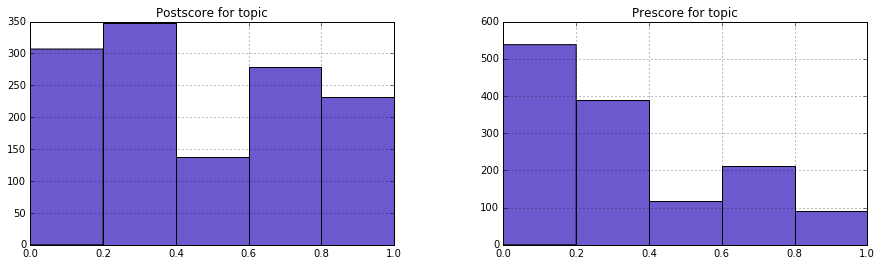

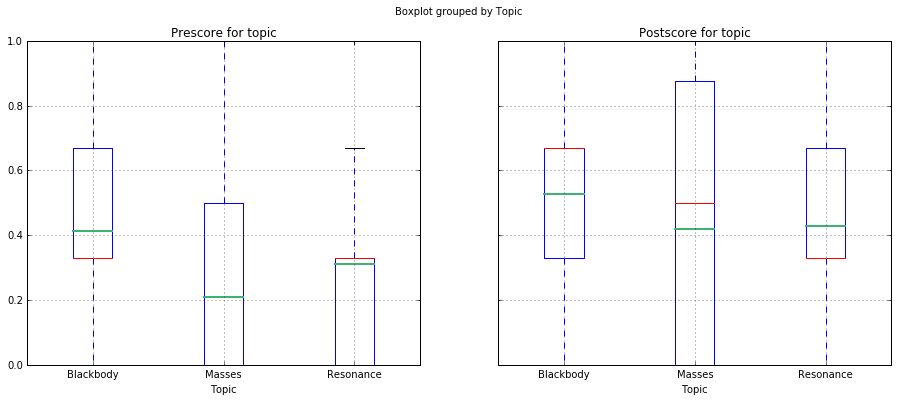

In [64]:
df.hist(column=['Prescore for topic','Postscore for topic'],bins=5, layout=(1,2),figsize=(15,4),color='slateblue')
meanlineprops = dict(linestyle='-', linewidth=2, color='mediumseagreen')
df.boxplot(by='Topic',
                column=['Prescore for topic','Postscore for topic'],
                figsize=(15,6),
                meanprops=meanlineprops, meanline=True, showmeans=True)

We can see from the histograms that we a wide spectrum of knowledge levels. The boxplots confirm that the student did indeed learn, as post-scores increased for all topics though in varying amounts per topic. We do a Mann-Whitney test (the equivalent a simple t-test for non normal data) to find out if the difference in score is significant.

In [65]:
from scipy.stats import mannwhitneyu
m = mannwhitneyu(df[df['Topic']=='Masses']['Prescore for topic'],df[df['Topic']=='Masses']['Postscore for topic'])
r = mannwhitneyu(df[df['Topic']=='Resonance']['Prescore for topic'],df[df['Topic']=='Resonance']['Postscore for topic'])
b = mannwhitneyu(df[df['Topic']=='Blackbody']['Prescore for topic'],df[df['Topic']=='Blackbody']['Postscore for topic'])
print("The significance of the post score difference is:\n{0} for Masses, \n{1} for Resonance, \n{2} for Blackbody".format(m,r,b))

The significance of the post score difference is:
MannwhitneyuResult(statistic=95307.0, pvalue=2.2123823670513139e-15) for Masses, 
MannwhitneyuResult(statistic=98824.0, pvalue=3.5489988668011413e-12) for Resonance, 
MannwhitneyuResult(statistic=116252.0, pvalue=0.001570114610541258) for Blackbody


Next we look at the time spent on task. Next let's look at how much time they spent on each activity.

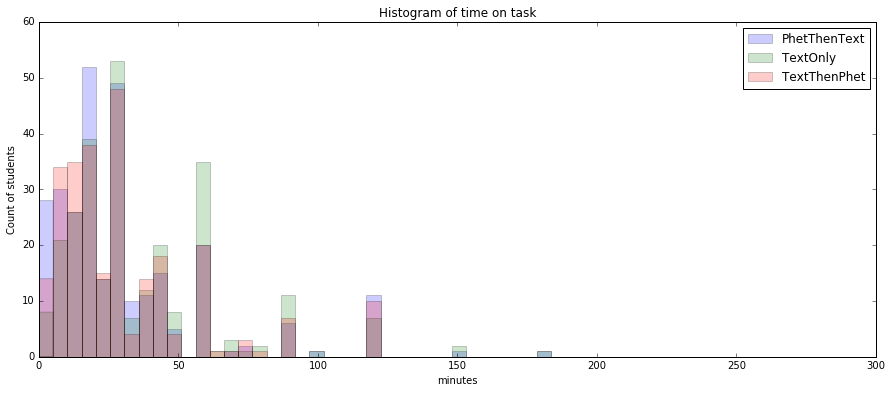

In [76]:
bins = np.linspace(0, 250, 50)
plt.figure(figsize=(15,6))
plt.hist(df[df['Treatment for topic']=='PhetThenText']['Time on text for topic'], bins, alpha=0.2, label='PhetThenText')
plt.hist(df[df['Treatment for topic']=='TextOnly']['Time on text for topic'], bins, alpha=0.2, label='TextOnly')
plt.hist(df[df['Treatment for topic']=='TextThenPhet']['Time on text for topic'], bins, alpha=0.2, label='TextThenPhet')
#plt.hist(df2['Time on PhET for topic'], bins, alpha=0.5, label='PhET')
plt.legend(loc='upper right');plt.xlabel('minutes');plt.ylabel('Count of students');plt.title('Histogram of time on task for reading per condition')

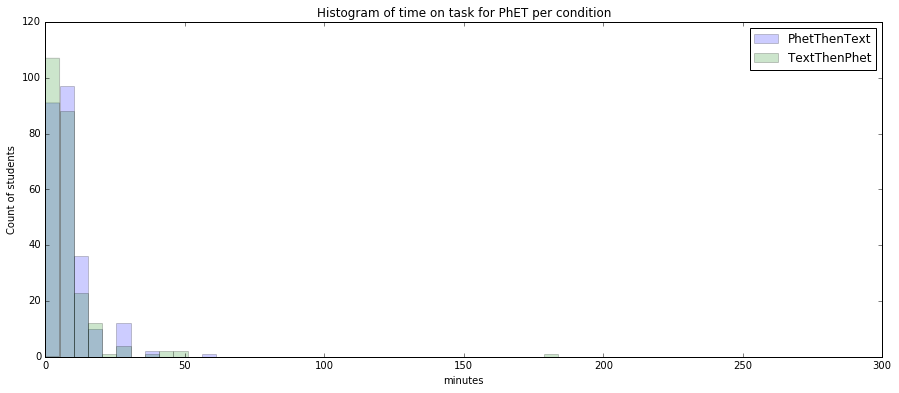

In [78]:
bins = np.linspace(0, 250, 50)
plt.figure(figsize=(15,6))
plt.hist(df2[df2['Treatment for topic']=='PhetThenText']['Time on PhET for topic'], bins, alpha=0.2, label='PhetThenText')
plt.hist(df2[df2['Treatment for topic']=='TextThenPhet']['Time on PhET for topic'], bins, alpha=0.2, label='TextThenPhet')
plt.legend(loc='upper right');plt.xlabel('minutes');plt.ylabel('Count of students');plt.title('Histogram of time on task for PhET per condition')

In [89]:
#df['Time on task overall'] = df['Time on text for topic'].apply(lambda x: x/np.max(df['Time on text for topic']))+df['Time on PhET for topic'].apply(lambda x: x/np.max(df['Time on PhET for topic']))
df['Time on task overall'] = df['Time on text for topic']+df['Time on PhET for topic']

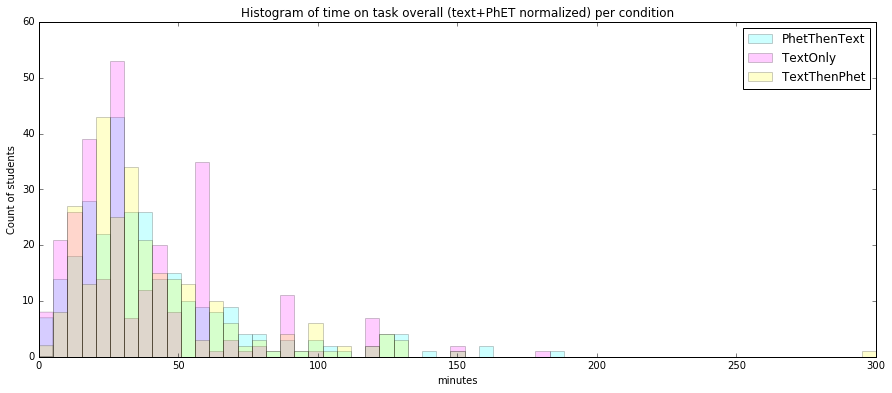

In [97]:
bins = np.linspace(0, 300, 60)
plt.figure(figsize=(15,6))
plt.hist(df[df['Treatment for topic']=='PhetThenText']['Time on task overall'], bins, alpha=0.2, label='PhetThenText',color='cyan')
plt.hist(df[df['Treatment for topic']=='TextOnly']['Time on task overall'], bins, alpha=0.2, label='TextOnly',color='magenta')
plt.hist(df[df['Treatment for topic']=='TextThenPhet']['Time on task overall'], bins, alpha=0.2, label='TextThenPhet', color='yellow')
plt.legend(loc='upper right');plt.xlabel('minutes');plt.ylabel('Count of students');plt.title('Histogram of time on task overall (text+PhET normalized) per condition')

Clearly more time was spent reading than using PhET, with very few students using PhET for more than 10 minutes. Let's now compare the performance of students given their time on task. First we provide definitions of "engagement" using median measures.

In [70]:
phet_median = df2[df2['Treatment for topic']!='TextOnly']['Time on PhET for topic'].median()
df2['Engaged PhET'] = df2[df2['Treatment for topic']!='TextOnly']['Time on PhET for topic'] > phet_median
text_median = df2['Time on text for topic'].median()
df2['Engaged text'] = df2['Time on text for topic'] > text_median
'The median engagment times for PhET and text are {0} and {1} minutes.'.format(phet_median,text_median)

C:\Users\sperez8\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\sperez8\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


'The median engagment times for PhET and text are 10.0 and 30.0 minutes.'

## Performance analysis by engagement

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000012178400>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000001227D208>], dtype=object)

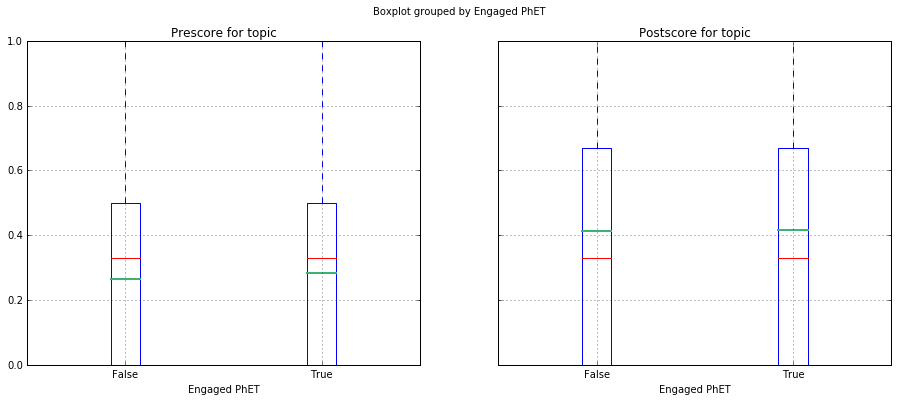

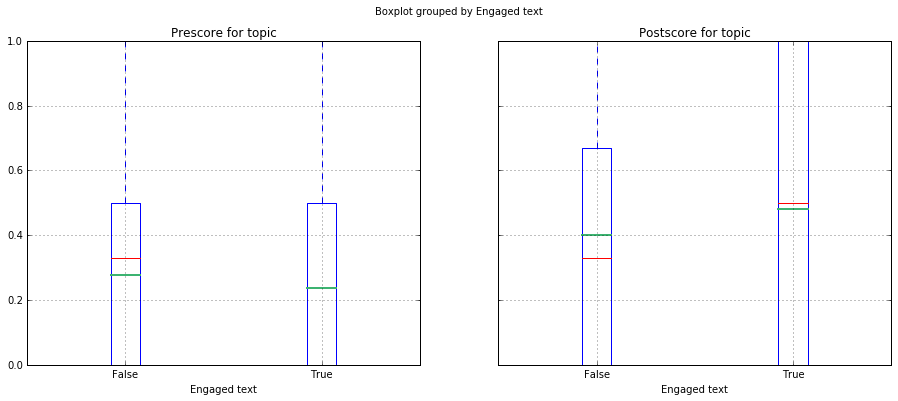

In [71]:
meanlineprops = dict(linestyle='-', linewidth=2, color='mediumseagreen')
df2.boxplot(by='Engaged PhET', column=['Prescore for topic','Postscore for topic'],
                figsize=(15,6), meanprops=meanlineprops, meanline=True, showmeans=True)
meanlineprops = dict(linestyle='-', linewidth=2, color='mediumseagreen')
df2.boxplot(by='Engaged text', column=['Prescore for topic','Postscore for topic'],
                figsize=(15,6), meanprops=meanlineprops, meanline=True, showmeans=True)

Those that engaged more with PhET had similar incoming knowledge and don't seem to have benefited from engaging with PhET. Those that engaged more in the reading seemed to have lower incoming knowledge and they perhaps benefited from the engagement.

Next let's group by engagement and see if there is a different in performance.

In [40]:
# from statsmodels.formula.api import ols
# t1 = df2[df2['Treatment for topic']!='TextOnly']
# t2 = df2[df2['Treatment for topic']=='TextOnly']
# t1.shape,t2.shape
# model = ols("'Postscore from topic' ~ 'Prescore total' ",df2)